# 1c) Check whether a tweet is harmful to society
- We have a train and test dataset.
- This is an supervised learning task because we have labels that define whether a tweet is harmful or not.
- All we need to do is train our algorithmns on based on these labels, and evaluate on the test dataset.

In [226]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import *
import random
import matplotlib.pyplot as plt
import numpy as np

## Data exploration
- First, lets explore our data:

In [162]:
df_test = pd.read_csv('data/1c/CT22_english_1C_harmful_dev_test.tsv', sep='\t')
df_train = pd.read_csv('data/1c/CT22_english_1C_harmful_train.tsv', sep='\t')

print("Test shape: {}\nTrain shape: {}".format(df_test.shape, df_train.shape))

df_train.head()

Test shape: (910, 5)
Train shape: (3323, 5)


,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",0
1,COVID-19,1.350166e+18,http://twitter.com/user/status/135016568806166...,Here’s what I’m doing while I wait my turn for...,0
2,COVID-19,1.369750e+18,http://twitter.com/user/status/136974953915491...,"This afternoon, I’m hosting an event with the ...",0
3,COVID-19,1.350165e+18,http://twitter.com/user/status/135016499568693...,"Help shops like mine stay open. Mask up, avoid...",0
4,COVID-19,1.370008e+18,http://twitter.com/user/status/137000807648978...,As part of the ongoing nationwide vaccination ...,0


Comment:
- There are 910 tweets in the test data set,
- and 3323 in the train data set.
- The only useful features for our task are the actual tweets and their labels

Checking for inconsistency:

In [163]:
# Train set uniques
print("Unique topics: {}".format(df_train['topic'].unique()))
print("Unique labels: {}".format(df_train['class_label'].unique()))

# Test set uniques
print("Unique topics: {}".format(df_test['topic'].unique()))
print("Unique labels: {}".format(df_test['class_label'].unique()))

Unique topics: ['COVID-19']
Unique labels: [0 1]
Unique topics: ['COVID-19']
Unique labels: [0 1]


In [164]:
print("Test NA-values: {}\n".format(df_test.isna().sum()))
print("Train NA-values: {}".format(df_train.isna().sum()))

Test NA-values: topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64

Train NA-values: topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64


Comment: No inconsistencies

<BarContainer object of 2 artists>

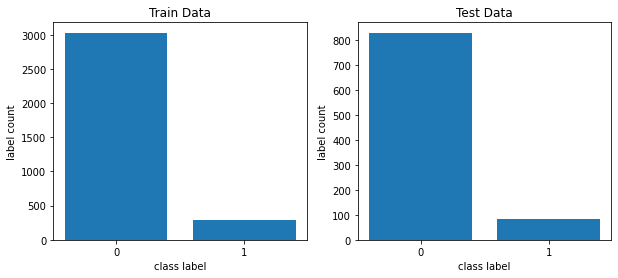

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

# Train data
train_data = df_train['class_label'].value_counts().to_dict()
ax1.set_title('Train Data')
ax1.set_xticks([0,1])
ax1.set_xlabel("class label")
ax1.set_ylabel("label count")
ax1.bar(train_data.keys(), train_data.values())

# Test data
test_data = df_test['class_label'].value_counts().to_dict()
ax2.set_title('Test Data')
ax2.set_xticks([0,1])
ax2.set_xlabel("class label")
ax2.set_ylabel("label count")
ax2.bar(test_data.keys(), test_data.values())

In [166]:
print(df_train['class_label'].value_counts())
print(df_test['class_label'].value_counts())

0    3031
1     292
Name: class_label, dtype: int64
0    828
1     82
Name: class_label, dtype: int64


Comment: 
- We can see that our data is highly imbalanced. 
- Around 91% of our data has are labeled with 0 (harmful tweets) and only around 9% are labeled with 1. 
- We have to keep this in mind when designing our models.

## Cleanup
To make our data easier to handle by our ML algorithms we need to pre process it:
The function below removes all special characters, URLs, stopwords, lammatizes words and makes them to lowercase.

In [167]:
# Removing stop words from: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

def preprocess(tweets):
    processed_list = []
    lemmatizer = WordNetLemmatizer()

    # URL PATTERN copied from: https://stackoverflow.com/questions/520031/whats-the-cleanest-way-to-extract-urls-from-a-string-using-python
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    STOP_WORDS = set(stopwords.words('english'))

    
    for tweet in tweets:
        tweet = re.sub(URL_PATTERN, '', tweet)
        tweet = tweet.lower()
        tweet = re.sub('\d', '', tweet) # Remove digits
        tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet) # Remove all special charaters
        tokens = word_tokenize(tweet)
        tweet = [lemmatizer.lemmatize(word) for word in tokens if not word in STOP_WORDS] # Lemmatize and remove stop words
        tweet = " ".join(tweet)
        processed_list.append(tweet)
    return processed_list

tweets_train = preprocess(df_train['tweet_text'].to_list())
tweets_test = preprocess(df_test['tweet_text'].to_list())


A random tweet before and after:

In [168]:
index = random.randint(0, len(df_train['tweet_text'].to_list()))

print("Before:\n" + df_train['tweet_text'].to_list()[index])
print("\nAfter:\n" + tweets_train[index])

Before:
BREAKING: Coalition fails in bid to source extra Covid-19 vaccines from EU and UK. In other news, HSE chief executive Paul Reid’s salary increases to €420,103.

After:
breaking coalition fails bid source extra covid vaccine eu uk news hse chief executive paul reid salary increase


Most common n words in the train data set:

In [169]:
from collections import Counter

def get_most_common(n):
    counter = Counter()
    for tweet in tweets_train:
        for word in tweet.split():
            counter[word] += 1
    return counter.most_common(n)
    
get_most_common(9)

[('vaccine', 4107),
 ('covid', 2968),
 ('people', 406),
 ('get', 392),
 ('u', 364),
 ('amp', 340),
 ('health', 324),
 ('coronavirus', 312),
 ('country', 266)]

# Training the algorithmn
- Since we are dealing with an highly imbalanced data set, we will be using Complement Naive Bayes algorithm to train our model, which is specifically designed imbalanced datasets. (https://scikit-learn.org/stable/modules/naive_bayes.html)
- For evaluation we will use classification report module which outputs accuracy, f1-score and recall.

In [269]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(tweets_train)

X_test = vectorizer.transform(tweets_test)
X_train = vectorizer.transform(tweets_train)

y_train = df_train['class_label'].to_list()
y_test = df_test['class_label'].to_list()


Naive bayes (with different variations):

In [270]:
gnb = GaussianNB()
y_pred_guassianNB = gnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [271]:
mnb = MultinomialNB()
y_pred_multinomialNB = mnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [272]:
cnb = ComplementNB()
y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [273]:
bnb = BernoulliNB()
y_pred_bernoulliNB = bnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

# Evaluation

In [274]:
print(classification_report(y_test, y_pred_guassianNB))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       828
           1       0.31      0.15      0.20        82

    accuracy                           0.89       910
   macro avg       0.61      0.56      0.57       910
weighted avg       0.86      0.89      0.88       910



In [275]:
print(classification_report(y_test, y_pred_multinomialNB))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       828
           1       0.56      0.06      0.11        82

    accuracy                           0.91       910
   macro avg       0.74      0.53      0.53       910
weighted avg       0.88      0.91      0.88       910



In [276]:
print(classification_report(y_test, y_pred_complementNB))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       828
           1       0.42      0.20      0.27        82

    accuracy                           0.90       910
   macro avg       0.67      0.58      0.61       910
weighted avg       0.88      0.90      0.89       910



In [277]:
print(classification_report(y_test, y_pred_bernoulliNB, zero_division=False)) # zero_division is for warning supression.

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       828
           1       0.00      0.00      0.00        82

    accuracy                           0.91       910
   macro avg       0.45      0.50      0.48       910
weighted avg       0.83      0.91      0.87       910



Comment:
- From the classification reports above we can see that the models are not good for classifying the 1-labels. 
- Some models have high precision, but low recall or the other way around. This leads to a low f1-score, which is a combination of precision and recall.
- We can see that the complementNB model has the best f1-result for 1-labels, which makes because it's designed for skewed data sets.
- We will continue to try different parameters on complementNB model to try to improve the results.

In [285]:
def test_alphas(alphas):
    for alpha in alphas:
        cnb = ComplementNB(alpha=alpha)
        y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())
        print("Alpha: {:.2f}, f1-score: {:.2f}".format(alpha, f1_score(y_test, y_pred_complementNB))) 

test_alphas(alphas = np.arange(1.0e-10, 1.1, 0.1))

Alpha: 0.00, f1-score: 0.20
Alpha: 0.10, f1-score: 0.34
Alpha: 0.20, f1-score: 0.34
Alpha: 0.30, f1-score: 0.37
Alpha: 0.40, f1-score: 0.37
Alpha: 0.50, f1-score: 0.32
Alpha: 0.60, f1-score: 0.34
Alpha: 0.70, f1-score: 0.34
Alpha: 0.80, f1-score: 0.32
Alpha: 0.90, f1-score: 0.30
Alpha: 1.00, f1-score: 0.27


In [284]:
cnb = ComplementNB(alpha=0.35)
y_pred_complementNB = cnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())
print(classification_report(y_test, y_pred_complementNB))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       828
           1       0.35      0.40      0.38        82

    accuracy                           0.88       910
   macro avg       0.65      0.66      0.66       910
weighted avg       0.89      0.88      0.88       910

